In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# import ensemble methods
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier,
)
from xgboost import XGBClassifier

# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(
    "ignore", category=DeprecationWarning
)  # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=[
        "#4B9AC7",
        "#4BE8E0",
        "#9DD4F3",
        "#97FBF6",
        "#2A7FAF",
        "#23B1AB",
        "#0E3449",
        "#015955",
    ]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg"  # to be replaced by "iframe" if working on JULIE

In [2]:
df = pd.read_csv('conversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


### LOGISTIC REGRESSION BASELINE 

In [3]:
target_variable = 'converted'
X = df.drop([target_variable], axis=1)
y = df[target_variable]


In [4]:
numerical_features = ['age', 'total_pages_visited']
categorical_features = ['country', 'new_user', 'source']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### TEMPLATE PREPROCESSING

In [1]:
'''
# Création du pipeline pour les variables quantitatives
numeric_features = [1,2,3] # Positions des colonnes quantitatives dans X
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # pour normaliser les variables
])

# Création du pipeline pour les variables catégorielles
categorical_features = [0] # Positions des colonnes catégorielles dans X
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first')) # on encode les catégories sous forme de colonnes comportant des 0 et des 1
    ])

# On combine les pipelines dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
'''

"\n# Création du pipeline pour les variables quantitatives\nnumeric_features = [1,2,3] # Positions des colonnes quantitatives dans X\nnumeric_transformer = Pipeline(steps=[\n    ('scaler', StandardScaler()) # pour normaliser les variables\n])\n\n# Création du pipeline pour les variables catégorielles\ncategorical_features = [0] # Positions des colonnes catégorielles dans X\ncategorical_transformer = Pipeline(\n    steps=[\n    ('encoder', OneHotEncoder(drop='first')) # on encode les catégories sous forme de colonnes comportant des 0 et des 1\n    ])\n\n# On combine les pipelines dans un ColumnTransformer\npreprocessor = ColumnTransformer(\n    transformers=[\n        ('num', numeric_transformer, numeric_features),\n        ('cat', categorical_transformer, categorical_features)\n    ])\n"

In [6]:
# numerical_imputer = SimpleImputer(strategy='mean') mais pas besoin car pas de valeurs manquantes
numerical_scaler = StandardScaler()

# categorical_imputer = SimpleImputer(strategy='constant', fill_value='UNKNOWN') mais pas besoin car pas de valeurs manquantes
categorical_encoder = OneHotEncoder(drop='first')

# Group our transformers

numeric_pipeline = Pipeline([
  #('numeric_imputer', numerical_imputer),
  ('numeric_scaler', numerical_scaler)
])

categoric_pipeline = Pipeline([
  #('categoric_imputer', categorical_imputer),
  ('categoric_encoder', categorical_encoder)
])

preprocessor = ColumnTransformer([
  ('numeric_pipeline', numeric_pipeline, numerical_features),
  ('categoric_pipeline', categoric_pipeline, categorical_features),
])

In [7]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [8]:
reg_log = LogisticRegression()
reg_log.fit(X_train, y_train)


y_train_pred = reg_log.predict(X_train)
y_test_pred = reg_log.predict(X_test)

print(f"Accuracy on train set is {accuracy_score(y_train, y_train_pred)}")
print(f"f1_score on train set is {f1_score(y_train, y_train_pred)}")
print(f"Accuracy on test set is {accuracy_score(y_test, y_test_pred)}")
print(f"f1_score on test set is {f1_score(y_test, y_test_pred)}")

from sklearn.metrics import precision_score, recall_score
print(f"Precision score is {precision_score(y_test, y_test_pred)}") #proportion de vrais positifs parmi tous les positifs PREDITS
print(f"Recall score is {recall_score(y_test, y_test_pred)}")#propostion de vrais positifs détectés parmis tous les positifs REELS


Accuracy on train set is 0.9861418581769625
f1_score on train set is 0.7617969044922612
Accuracy on test set is 0.9865591397849462
f1_score on test set is 0.7678300455235205
Precision score is 0.8670322138450994
Recall score is 0.6889978213507625


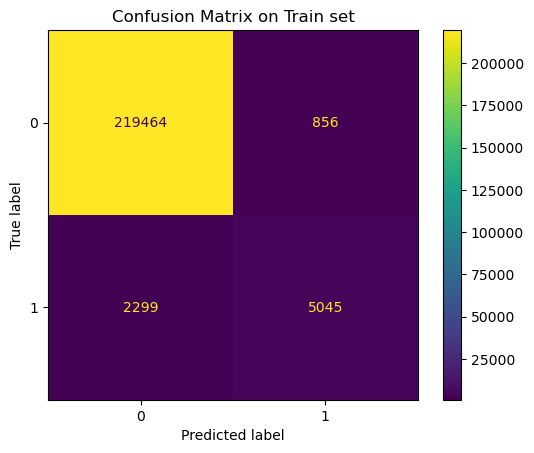

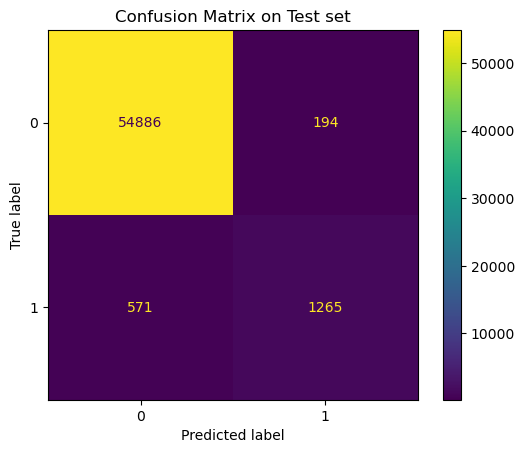

In [9]:
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    reg_log, X_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    reg_log, X_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

### BAGGING CLASSIFIER

In [12]:
bagging = BaggingClassifier(estimator=reg_log, n_estimators=10, random_state=42)

bagging.fit(X_train, y_train)

y_train_pred_bag = bagging.predict(X_train)
y_test_pred_bag = bagging.predict(X_test)


print(f"Accuracy on train set is {accuracy_score(y_train, y_train_pred_bag)}")
print(f"f1_score on train set is {f1_score(y_train, y_train_pred_bag)}")
print(f"Accuracy on test set is {accuracy_score(y_test, y_test_pred_bag)}")
print(f"f1_score on test set is {f1_score(y_test, y_test_pred_bag)}")

from sklearn.metrics import precision_score, recall_score
print(f"Precision score is {precision_score(y_test, y_test_pred_bag)}") #proportion de vrais positifs parmi tous les positifs PREDITS
print(f"Recall score is {recall_score(y_test, y_test_pred_bag)}")


Accuracy on train set is 0.9861550354908989
f1_score on train set is 0.7622567506411223
Accuracy on test set is 0.9864712910253707
f1_score on test set is 0.7668079951544519
Precision score is 0.8635743519781719
Recall score is 0.6895424836601307


## TEST

In [ ]:


X = np.append(X_train, X_test, axis=0)
y = np.append(y_train, y_test)

gridsearch.fit(X, y)
df_test = pd.read_csv('conversion_data_test.csv')
X_without_labels = df_test.drop(['age'], axis=1)
X_without_labels = preprocessor.transform(X_without_labels)

gridsearch.predict(X_without_labels)



NameError: name 'gridsearch' is not defined

In [ ]:
data = {
    'converted': gridsearch.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_Clement-tikitaka.csv', index=False)